# FD00-Combined

In [1]:
!wget https://ti.arc.nasa.gov/c/6/ -O data.zip
!unzip data.zip
!pip install lifelines

--2021-04-30 16:42:31--  https://ti.arc.nasa.gov/c/6/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip [following]
--2021-04-30 16:42:31--  https://ti.arc.nasa.gov/m/project/prognostic-repository/CMAPSSData.zip
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 12425978 (12M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  11.85M  3.32MB/s    in 6.7s    

2021-04-30 16:42:38 (1.76 MB/s) - ‘data.zip’ saved [12425978/12425978]

Archive:  data.zip
  inflating: Damage Propagation Modeling.pdf  
  inflating: readme.txt              
  inflating: RUL_FD001.txt           
  inflating: RUL_FD002.txt           
  inflating: RUL_FD003.txt 

In [2]:
# load necessary packages
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from tqdm.notebook import trange
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error, r2_score
from lifelines import KaplanMeierFitter, CoxTimeVaryingFitter
%matplotlib inline

In [3]:
inputdir = ""

#seed for reproducability
np.random.seed(1234)  
PYTHONHASHSEED = 0

# Preparing datasets

In [4]:
# the files did not contain headers. Here we create labels based on documentation
target_var = ['Target_Remaining_Useful_Life']
index_columns_names =  ["UnitNumber","Cycle"]
op_settings_columns = ["Op_Setting_"+str(i) for i in range(1,4)]
sensor_columns =["Sensor_"+str(i) for i in range(1,22)]
na_columns = ["NA1", "NA2"]
column_names = index_columns_names + op_settings_columns + sensor_columns + na_columns

# load data
#FD001
df_train_1 = pd.read_csv(inputdir+'train_FD001.txt', sep=" ", header=None, names = column_names)
df_test_1 = pd.read_csv(inputdir+'test_FD001.txt', sep=" ", header=None, names = column_names)

#FD002
df_train_2 = pd.read_csv(inputdir+'train_FD002.txt', sep=" ", header=None, names = column_names)
df_test_2 = pd.read_csv(inputdir+'test_FD002.txt', sep=" ", header=None, names = column_names)

#FD003
df_train_3 = pd.read_csv(inputdir+'train_FD003.txt', sep=" ", header=None, names = column_names)
df_test_3 = pd.read_csv(inputdir+'test_FD003.txt', sep=" ", header=None, names = column_names)

#FD004
df_train_4 = pd.read_csv(inputdir+'train_FD004.txt', sep=" ", header=None, names = column_names)
df_test_4 = pd.read_csv(inputdir+'test_FD004.txt', sep=" ", header=None, names = column_names)


In [5]:
#modify unit number of train set
df_train_2['UnitNumber'] = df_train_2['UnitNumber'] + 100
df_train_3['UnitNumber'] = df_train_3['UnitNumber'] + 360
df_train_4['UnitNumber'] = df_train_4['UnitNumber'] + 460

In [6]:
#modify unit number of test set
df_test_2['UnitNumber'] = df_test_2['UnitNumber'] + 100
df_test_3['UnitNumber'] = df_test_3['UnitNumber'] + 359
df_test_4['UnitNumber'] = df_test_4['UnitNumber'] + 459

In [7]:
#combine data
combined_train = [df_train_1, df_train_2, df_train_3, df_train_4]
combined_test = [df_test_1, df_test_2, df_test_3, df_test_4]

df_train = pd.concat(combined_train)
df_train = df_train.reset_index()

df_test = pd.concat(combined_test)
df_test = df_test.reset_index()

In [8]:
# drop index and NULL columns
df_train.drop(df_train.columns[[0, 27, 28]], axis=1, inplace=True)
df_test.drop(df_test.columns[[0, 27, 28]], axis=1, inplace=True)

display(df_train)

,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.30,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.30,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.30,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.30,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.30,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,709,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,15.46,404.59,2319.66,8840.16,1.27,46.08,380.16,2388.73,8185.69,8.4541,0.03,372,2319,100.0,29.11,17.5234
160355,709,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,21.57,567.59,2388.47,9117.12,1.31,48.04,535.02,2388.46,8185.47,8.2221,0.03,396,2388,100.0,39.38,23.7151
160356,709,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,21.57,569.04,2388.51,9126.53,1.31,48.24,535.41,2388.48,8193.94,8.2525,0.03,395,2388,100.0,39.78,23.8270
160357,709,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,7.96,199.93,2223.78,8403.64,1.05,42.53,187.92,2388.83,8125.64,9.0515,0.02,337,2223,100.0,15.26,9.0774


# Adding Failure indicators and Cycle starts

In [9]:
df_train["IsFailure"] = 0
idx_failure = (np.where(df_train["Cycle"] ==1)[0] - 1)[1:]
df_train["IsFailure"][idx_failure] = 1
df_train["CycleStart"] = df_train["Cycle"]-1
df_train


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,UnitNumber,Cycle,Op_Setting_1,Op_Setting_2,Op_Setting_3,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.30,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.30,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,0,1
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.30,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,0,2
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.30,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,0,3
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.30,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,709,251,9.9998,0.2500,100.0,489.05,605.33,1516.36,1315.28,10.52,15.46,404.59,2319.66,8840.16,1.27,46.08,380.16,2388.73,8185.69,8.4541,0.03,372,2319,100.0,29.11,17.5234,0,250
160355,709,252,0.0028,0.0015,100.0,518.67,643.42,1598.92,1426.77,14.62,21.57,567.59,2388.47,9117.12,1.31,48.04,535.02,2388.46,8185.47,8.2221,0.03,396,2388,100.0,39.38,23.7151,0,251
160356,709,253,0.0029,0.0000,100.0,518.67,643.68,1607.72,1430.56,14.62,21.57,569.04,2388.51,9126.53,1.31,48.24,535.41,2388.48,8193.94,8.2525,0.03,395,2388,100.0,39.78,23.8270,0,252
160357,709,254,35.0046,0.8400,100.0,449.44,555.77,1381.29,1148.18,5.48,7.96,199.93,2223.78,8403.64,1.05,42.53,187.92,2388.83,8125.64,9.0515,0.02,337,2223,100.0,15.26,9.0774,0,253


In [10]:
drop_sensors = op_settings_columns +['Sensor_1','Sensor_5','Sensor_6','Sensor_10','Sensor_16','Sensor_18','Sensor_19']
X = df_train.drop(labels=drop_sensors, axis=1)
X

,UnitNumber,Cycle,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,0,0
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,0,1
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,0,2
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,0,3
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160354,709,251,605.33,1516.36,1315.28,404.59,2319.66,8840.16,46.08,380.16,2388.73,8185.69,8.4541,372,29.11,17.5234,0,250
160355,709,252,643.42,1598.92,1426.77,567.59,2388.47,9117.12,48.04,535.02,2388.46,8185.47,8.2221,396,39.38,23.7151,0,251
160356,709,253,643.68,1607.72,1430.56,569.04,2388.51,9126.53,48.24,535.41,2388.48,8193.94,8.2525,395,39.78,23.8270,0,252
160357,709,254,555.77,1381.29,1148.18,199.93,2223.78,8403.64,42.53,187.92,2388.83,8125.64,9.0515,337,15.26,9.0774,0,253


In [11]:
df_test["IsFailure"] = 0
idx_failure = (np.where(df_test["Cycle"] ==1)[0] - 1)[1:]
df_test["IsFailure"][idx_failure] = 1
df_test["CycleStart"] = df_test["Cycle"]-1
X_test = df_test[X.columns]
X_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,UnitNumber,Cycle,Sensor_2,Sensor_3,Sensor_4,Sensor_7,Sensor_8,Sensor_9,Sensor_11,Sensor_12,Sensor_13,Sensor_14,Sensor_15,Sensor_17,Sensor_20,Sensor_21,IsFailure,CycleStart
0,1,1,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,0,0
1,1,2,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,0,1
2,1,3,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,0,2
3,1,4,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,0,3
4,1,5,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104892,707,277,550.30,1364.40,1129.17,138.34,2212.35,8351.73,42.30,130.87,2388.50,8112.61,9.4427,331,10.53,6.2620,0,276
104893,707,278,608.00,1494.75,1260.88,334.75,2324.23,8758.69,44.53,314.51,2388.33,8086.83,9.2772,366,24.33,14.6486,0,277
104894,707,279,555.92,1370.65,1130.97,194.92,2223.57,8370.49,42.33,182.76,2388.64,8100.84,9.3982,336,14.69,8.8389,0,278
104895,707,280,608.19,1489.11,1256.25,333.15,2324.19,8753.04,44.78,314.17,2388.37,8085.24,9.2727,366,24.44,14.6887,0,279


In [12]:
from lifelines import CoxPHFitter
cph = CoxTimeVaryingFitter()

cph.fit(X, id_col='UnitNumber', event_col='IsFailure', start_col='CycleStart', stop_col='Cycle')
cph.print_summary() 

<lifelines.CoxTimeVaryingFitter: fitted with 160359 periods, 709 subjects, 708 events>
         event col = 'IsFailure'
number of subjects = 709
 number of periods = 160359
  number of events = 708
partial log-likelihood = -2473.81
  time fit was run = 2021-04-30 16:42:46 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
Sensor_2    1.24       3.45       0.12             1.01             1.46                 2.75                 4.32
Sensor_3    0.08       1.09       0.01             0.07             0.10                 1.07                 1.11
Sensor_4    0.04       1.04       0.01             0.02             0.06                 1.03                 1.06
Sensor_7    0.00       1.00       0.08            -0.15             0.15                 0.86                 1.16
Sensor_8   -1.06       0.35       0.07            -1.20            -0.92                 0.30                 0.40
Sensor_9    0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
Sensor_11   4.40      81.51       0.32             3.78             5.02                43.76               151.83
Sensor_12  -0.06       0.94       0.08            -0.22             0.10                 0.80                 1.11
Sensor_13   0.70       2.00       0.06             0.58             0.81                 1.79                 2.24
Sensor_14  -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00
Sensor_15  -1.16       0.31       0.70            -2.54             0.22                 0.08                 1.25
Sensor_17   0.39       1.48       0.04             0.31             0.47                 1.37                 1.59
Sensor_20  -0.02       0.98       0.32            -0.64             0.60                 0.53                 1.83
Sensor_21   0.20       1.22       0.53            -0.84             1.23                 0.43                 3.42

               z      p   -log2(p)
covariate                         
Sensor_2   10.71 <0.005      86.46
Sensor_3    8.96 <0.005      61.45
Sensor_4    4.99 <0.005      20.66
Sensor_7    0.00   1.00       0.01
Sensor_8  -14.51 <0.005     156.14
Sensor_9    1.95   0.05       4.27
Sensor_11  13.87 <0.005     142.83
Sensor_12  -0.73   0.47       1.10
Sensor_13  12.19 <0.005     111.22
Sensor_14  -1.53   0.13       3.00
Sensor_15  -1.65   0.10       3.33
Sensor_17  10.07 <0.005      76.83
Sensor_20  -0.05   0.96       0.06
Sensor_21   0.37   0.71       0.49
---
Partial AIC = 4975.61
log-likelihood ratio test = 2939.82 on 14 df
-log2(p) of ll-ratio test = inf

In [13]:
#prediction
pred_cols = ['Cycle',
 'Sensor_2',
 'Sensor_3',
 'Sensor_4',
 'Sensor_7',
 'Sensor_8',
 'Sensor_9',
 'Sensor_11',
 'Sensor_12',
 'Sensor_13',
 'Sensor_14',
 'Sensor_15',
 'Sensor_17',
 'Sensor_20',
 'Sensor_21',
 'IsFailure',
 'CycleStart']

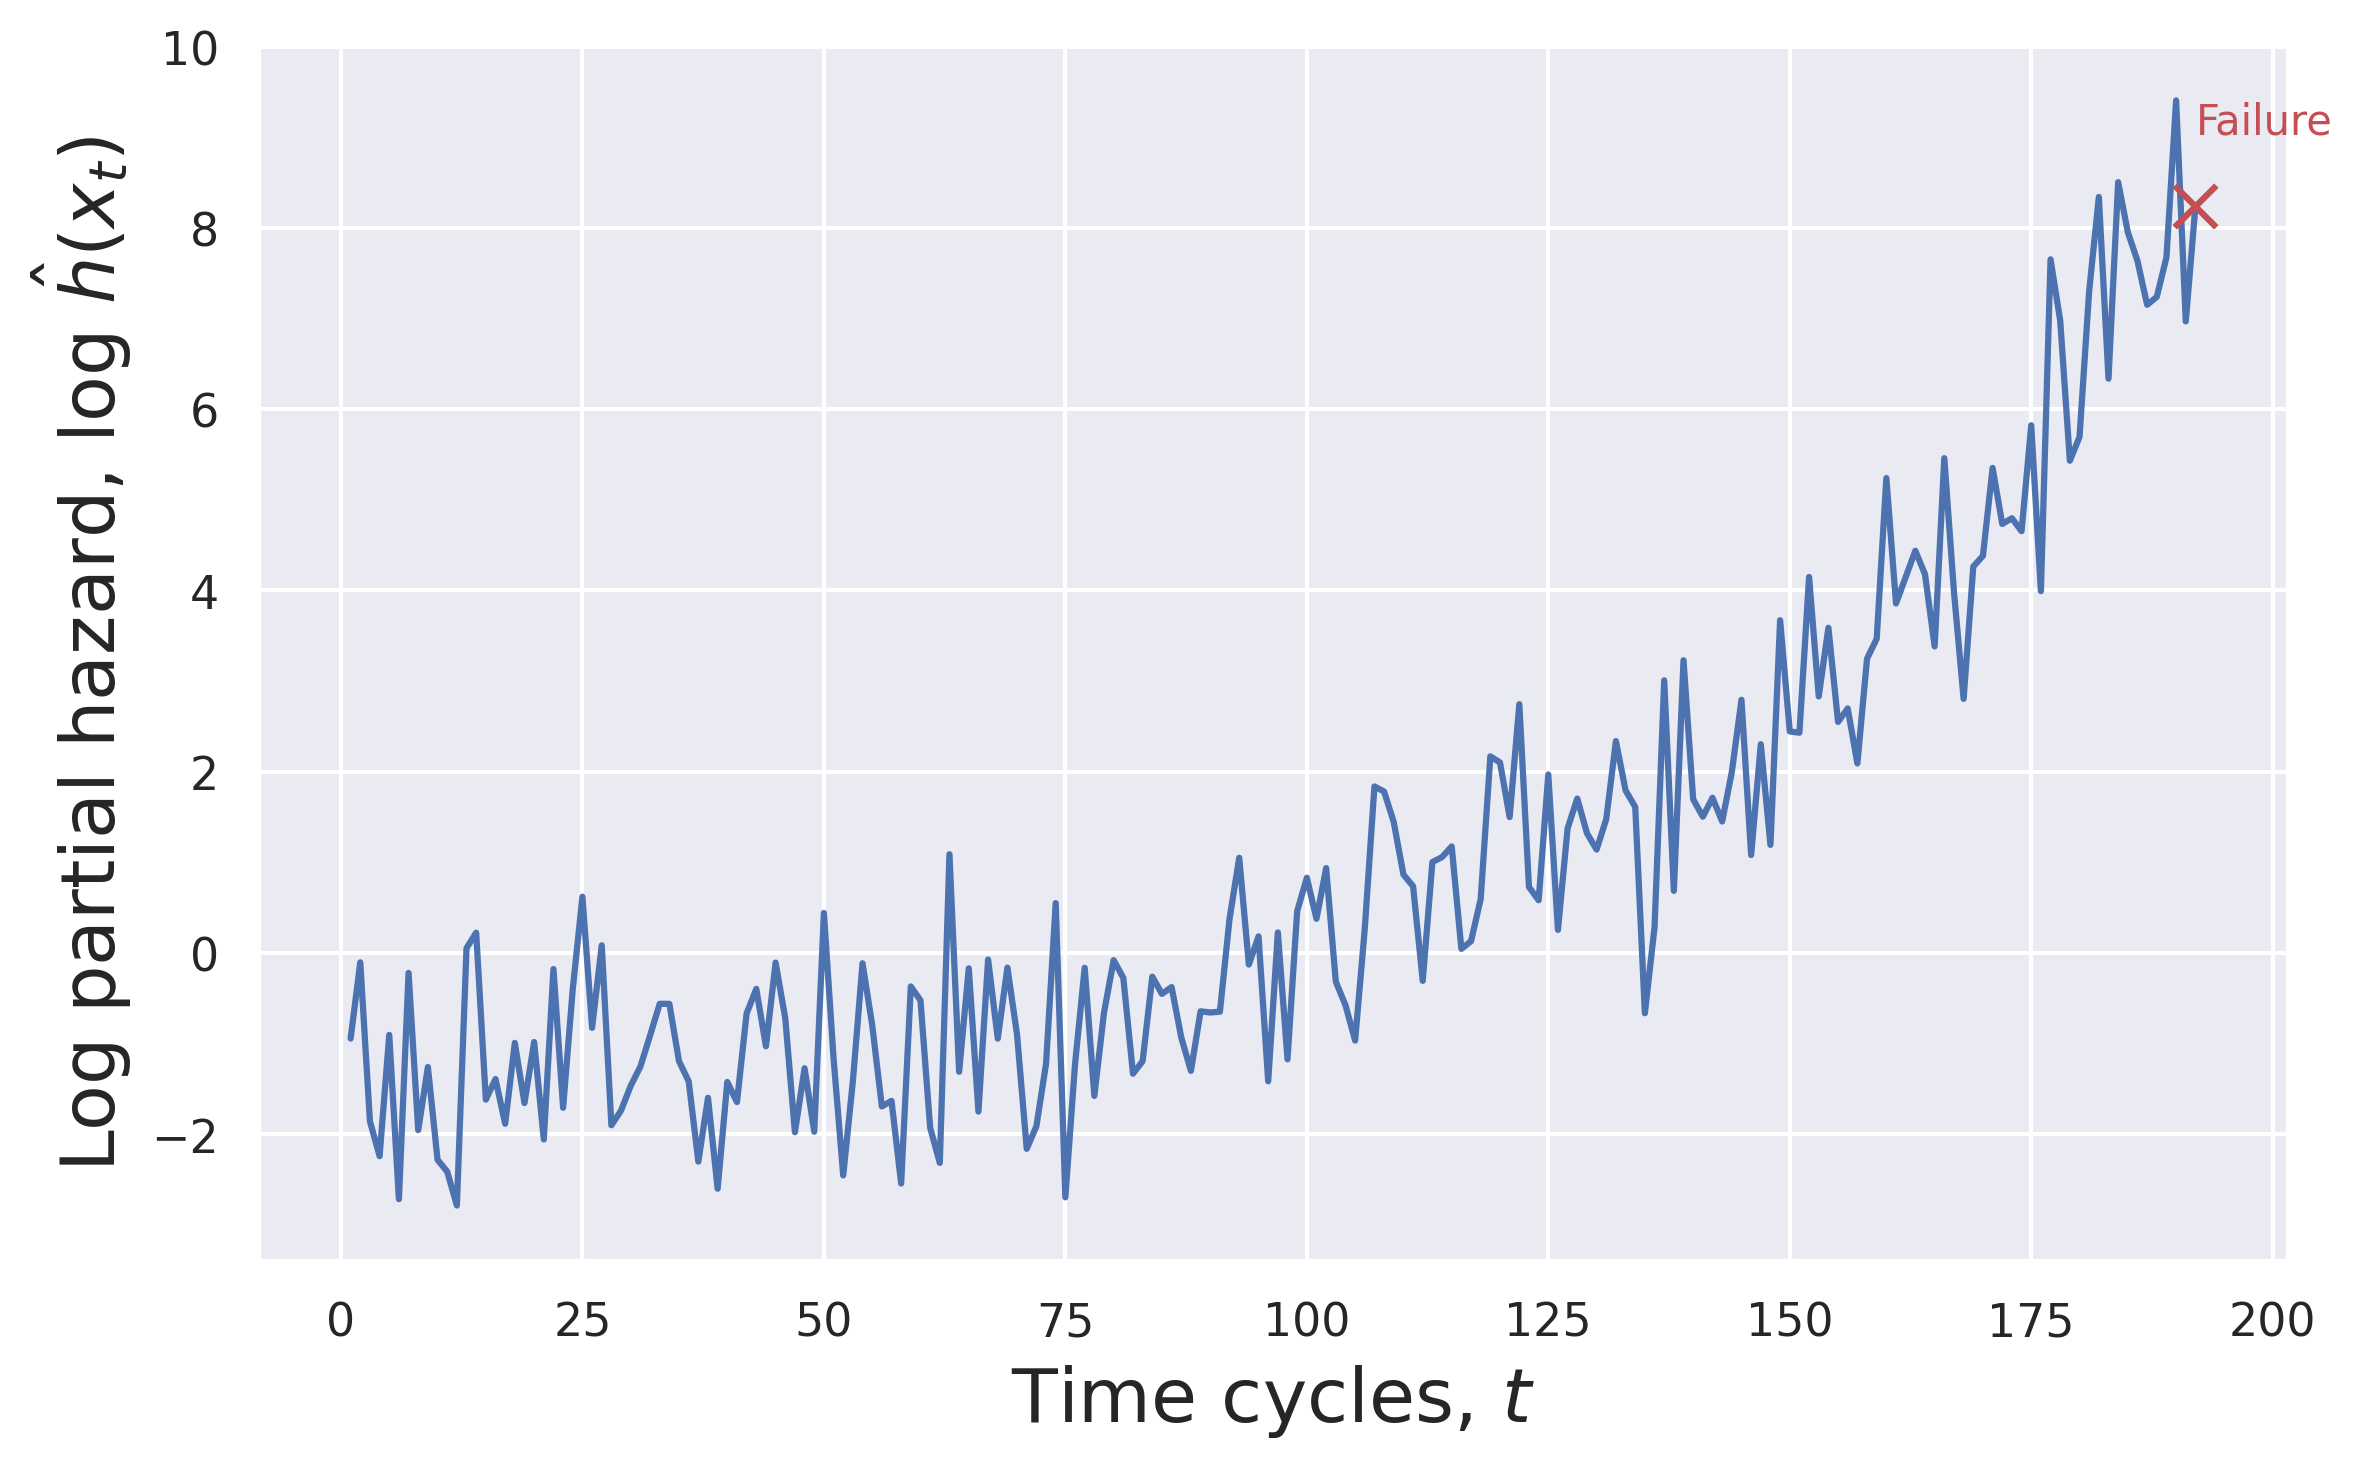

In [14]:
plt.figure(figsize=(8,5), dpi=300)


X_sub = X.loc[X['UnitNumber'] == 1]
predictions = cph.predict_partial_hazard(X_sub[pred_cols])
plt.plot(X_sub['Cycle'].values, np.log(predictions))
plt.scatter(np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1], s=100, marker="x", zorder=10, c="C3")
plt.text(np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]+0.8, "Failure", c="C3", fontsize=10)

plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.tight_layout()
plt.savefig('fd00x_hazard_traj.pdf', format="pdf")
plt.show()
  

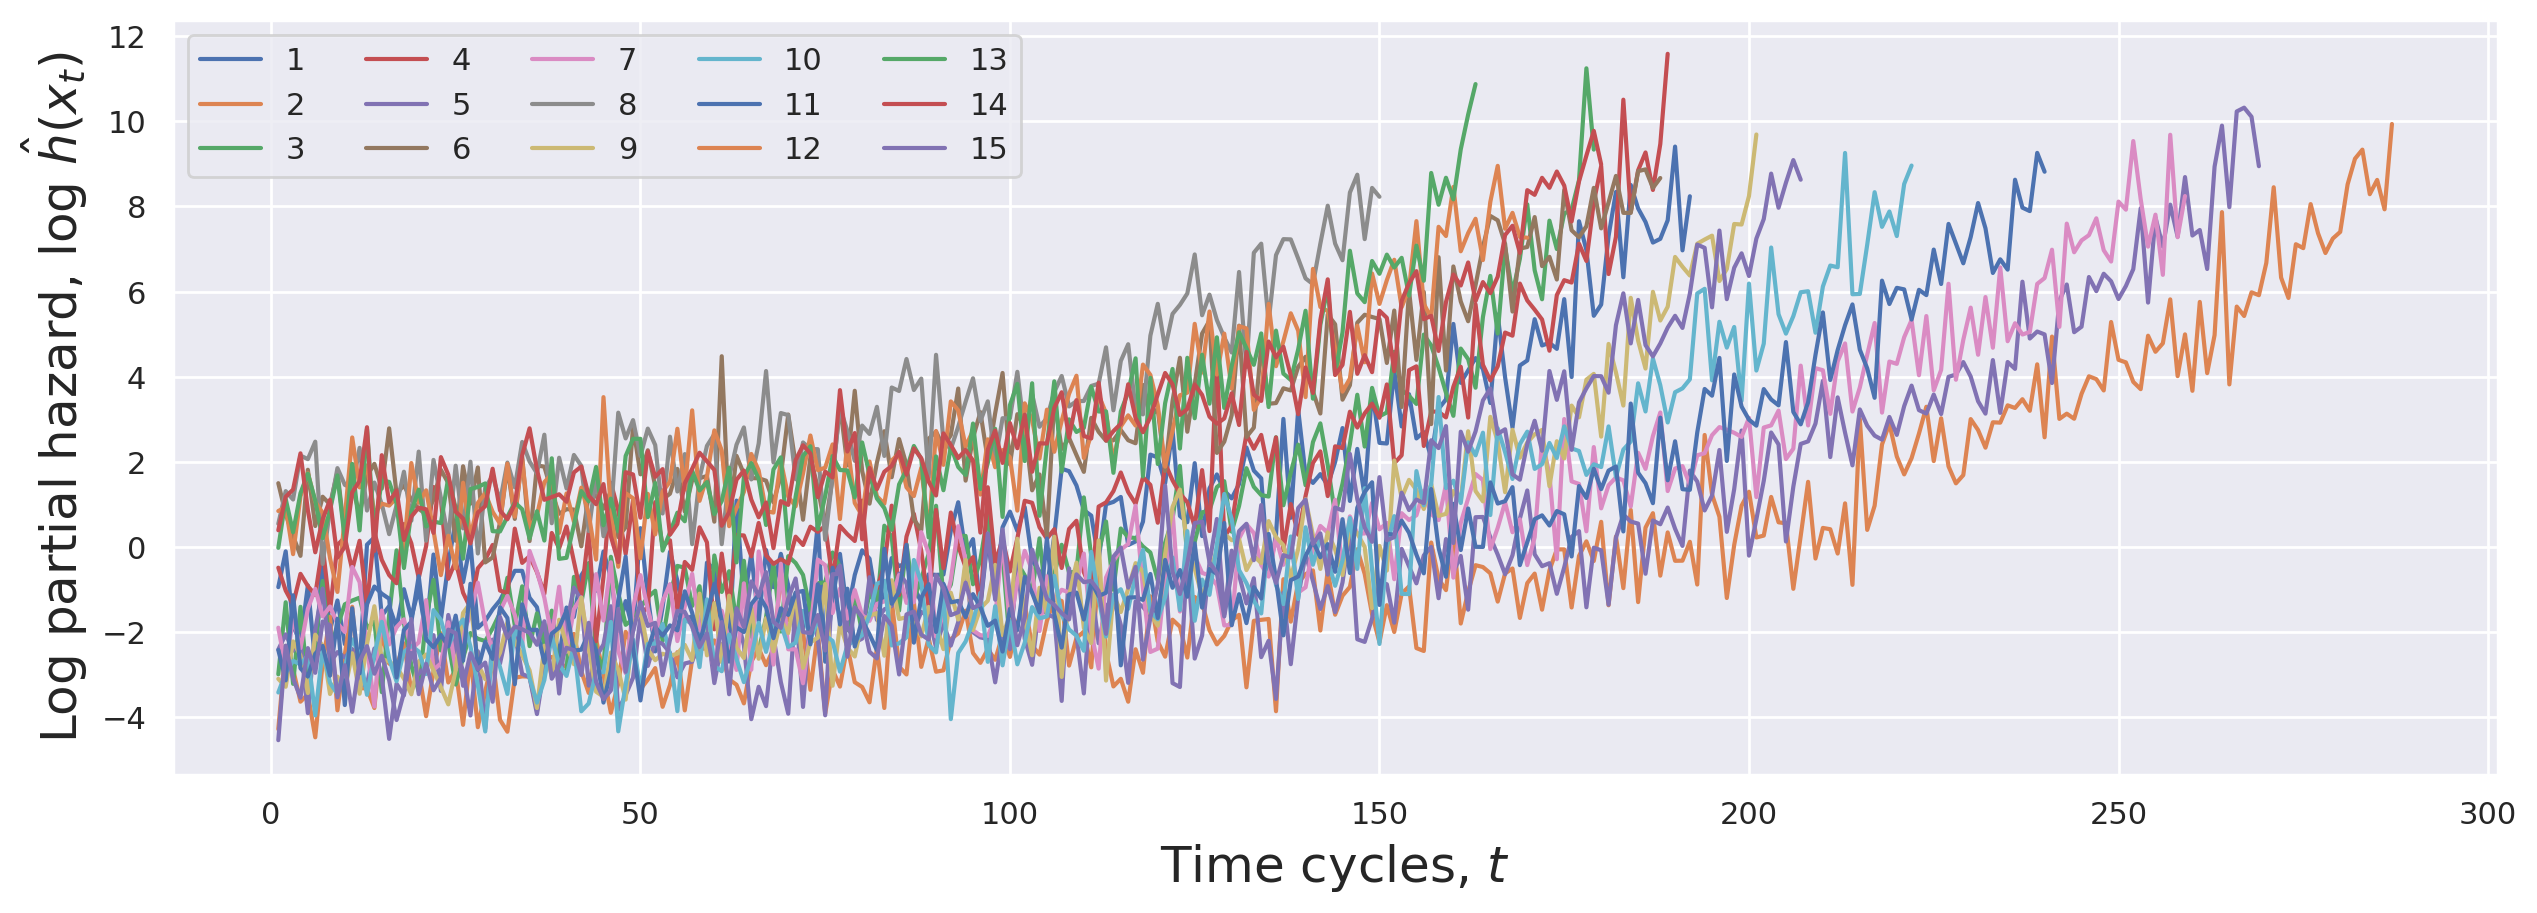

In [15]:
plt.figure(figsize=(15,5), dpi=200)

for i in trange(15):
    X_sub = X.loc[X['UnitNumber'] == i+1]
    predictions = cph.predict_partial_hazard(X_sub[pred_cols])
    plt.plot(X_sub['Cycle'].values, np.log(predictions), label=i+1)

plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.legend(ncol=5)
#plt.ylim([10, None])
plt.show()


# Thresholding the hazard score for decision making


In [16]:
#training

llp_replacement=4000000
perf_restoration=3500000

thres_list  = np.arange(5, 14, 0.5)


rep_num= 10
machine_num = 30

optim_data_mean = []
optim_data_std = []
for thres in thres_list :
  #simulate for rep_num times
  sim_results = []
  for k in trange(rep_num):
    #in each rep select machine_num machines
    machines = np.random.choice(X['UnitNumber'].unique(), size=machine_num)    
    machine_i = []
    for i in range(machine_num):
      X_sub = X.loc[X['UnitNumber'] == machines[i]]
      X_fail = X.loc[X['UnitNumber'] == machines[i]]['IsFailure']      
      predictions = cph.predict_partial_hazard(X_sub[pred_cols])

      m_maint = np.log(predictions) > thres 
      
      total_perf_rest = (m_maint.sum()>1) * perf_restoration      
      is_failed = m_maint.sum()==0
      total_llp_rep = is_failed*llp_replacement      
      total_maintcost = total_perf_rest + total_llp_rep
      
      machine_i.append([is_failed, total_perf_rest, total_llp_rep, total_maintcost])

    machine_i = np.array(machine_i)
    sim_result = [thres, machine_i[:, 0].mean(),  machine_i[:, 1].sum(),  
                  machine_i[:, 2].sum(),  machine_i[:, 3].sum()]
                  

    sim_results.append(sim_result)

  sim_results = np.array(sim_results)
  optim_data_mean.append(sim_results.mean(axis=0))
  optim_data_std.append(sim_results.std(axis=0))

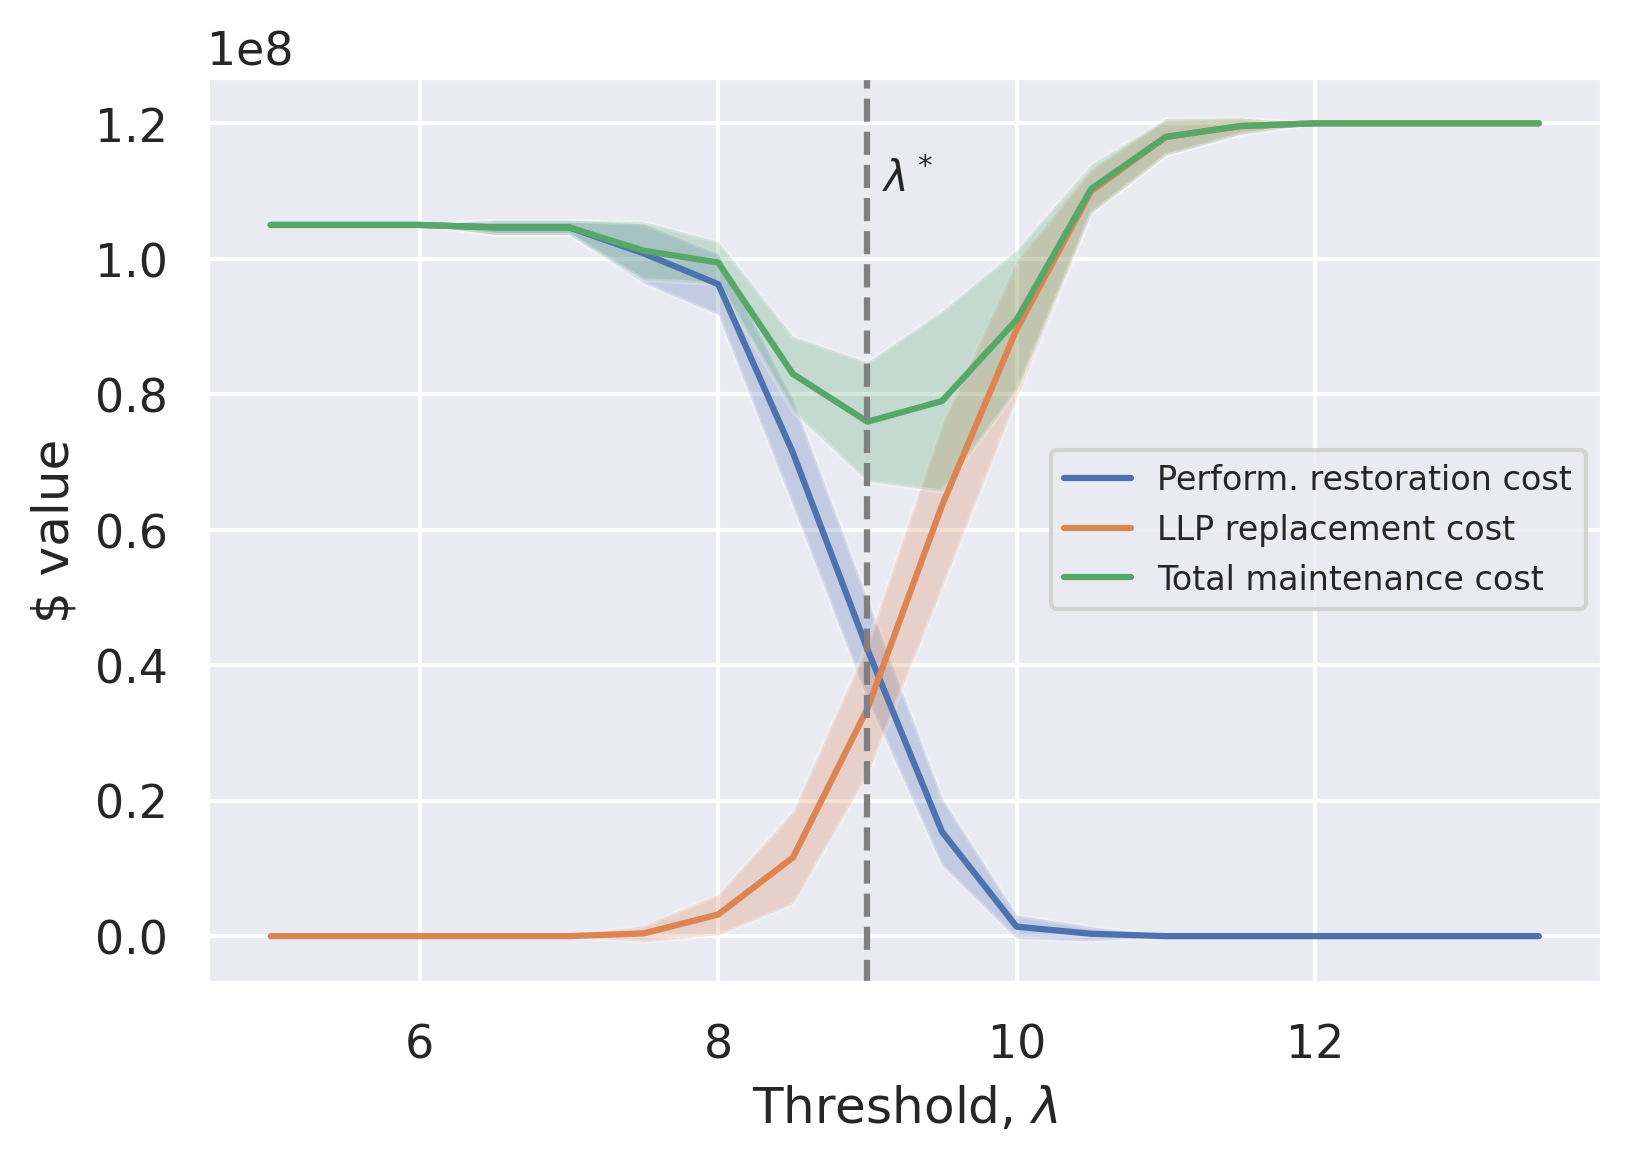

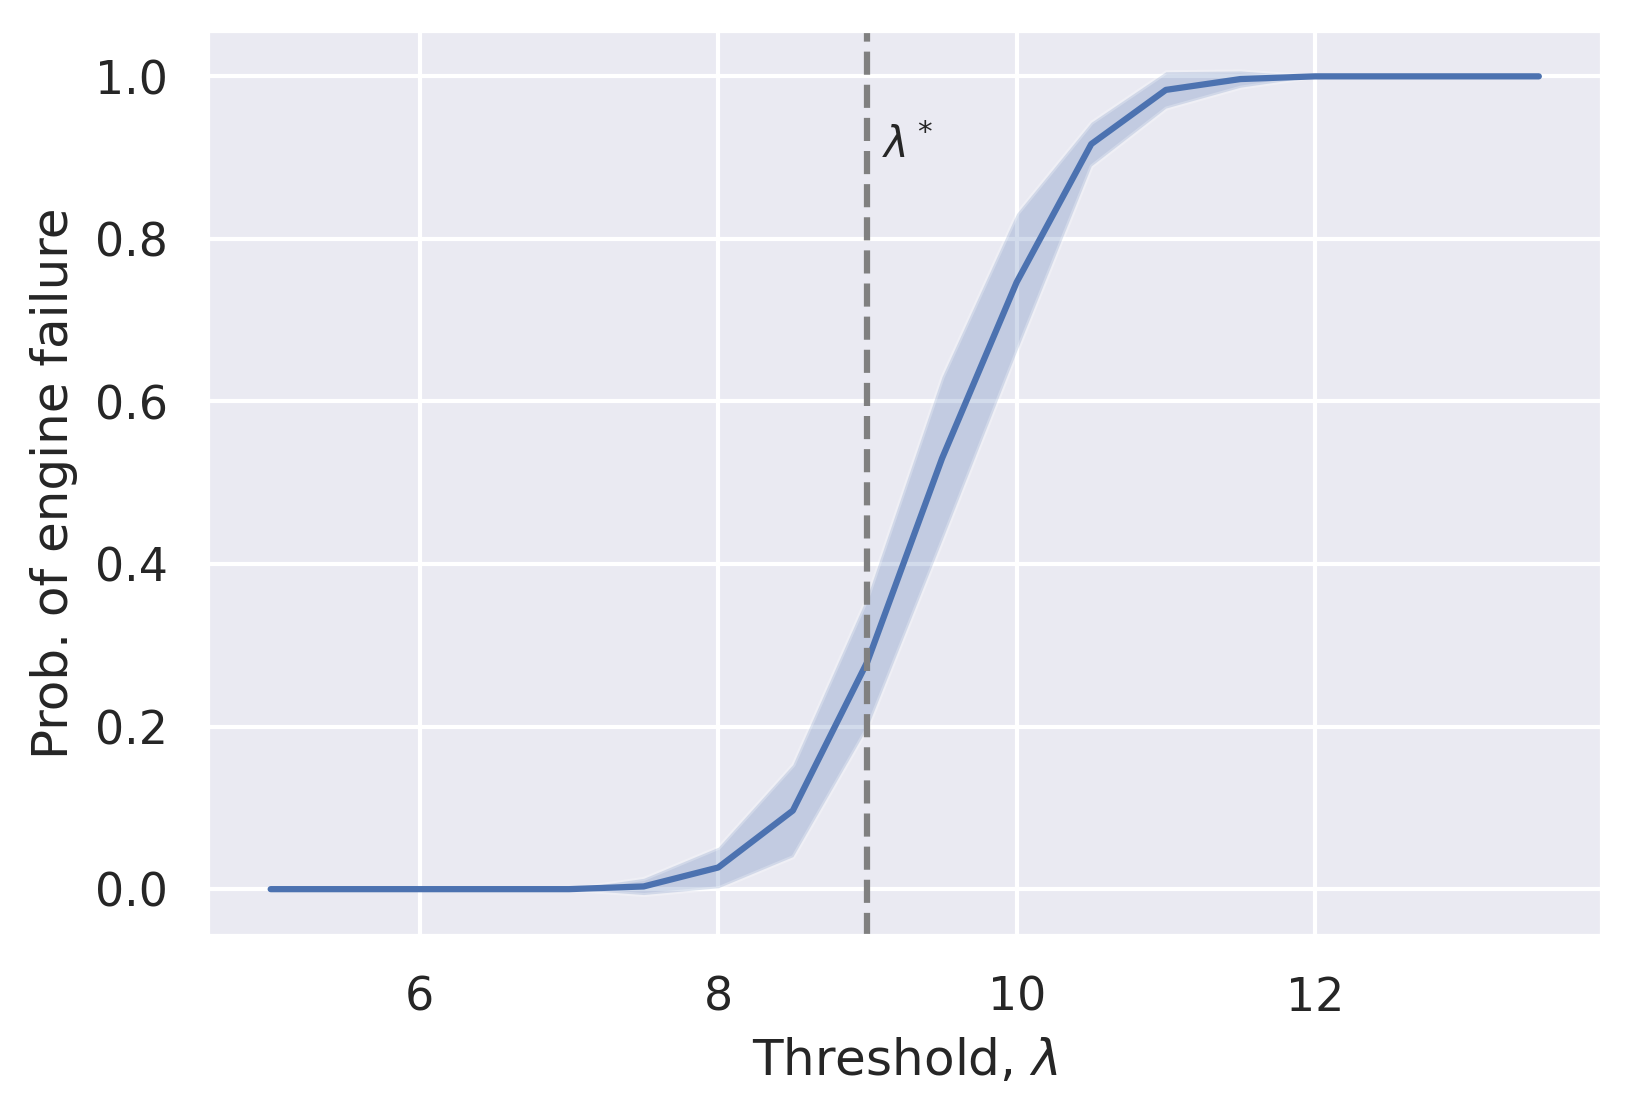

In [17]:
np.save('fd00x_mean_', np.array(optim_data_mean))
np.save('fd00x_std', np.array(optim_data_std))

mean_ = pd.DataFrame(np.array(optim_data_mean), columns=['thres', 'fail_prob', 'perf_rest', 'llp_rep', 'maint_cost'])
std_ = pd.DataFrame(np.array(optim_data_std), columns=['thres', 'fail_prob', 'perf_rest', 'llp_rep', 'maint_cost'])#

opt_thres_idx = mean_['maint_cost'].argmin()
opt_thres = thres_list[opt_thres_idx]

plt.figure(dpi=300)

plt.plot(thres_list, mean_['perf_rest'], label='Perform. restoration cost')
plt.fill_between(thres_list, mean_['perf_rest'] -std_['perf_rest'],  
                 mean_['perf_rest'] +std_['perf_rest'], alpha=0.25)

plt.plot(thres_list, mean_['llp_rep'], label='LLP replacement cost')
plt.fill_between(thres_list, mean_['llp_rep'] -std_['llp_rep'],  
                 mean_['llp_rep'] +std_['llp_rep'], alpha=0.25)

plt.plot(thres_list, mean_['maint_cost'], label='Total maintenance cost')
plt.fill_between(thres_list, mean_['maint_cost'] -std_['maint_cost'],  
                 mean_['maint_cost'] +std_['maint_cost'], alpha=0.25)

plt.axvline(opt_thres, c="gray", linestyle="dashed")
plt.text(opt_thres+0.1, 1.1e8, "$\lambda^*$")

plt.xlabel('Threshold, $\lambda$')
plt.ylabel('$ value')
plt.legend( fontsize=8)
plt.savefig('fd00x_cost.pdf', format="pdf")
plt.show()

plt.figure(dpi=300)
plt.plot(thres_list, mean_['fail_prob'], label='Engine failure probability')
plt.fill_between(thres_list, mean_['fail_prob'] -std_['fail_prob'],  
                 mean_['fail_prob'] +std_['fail_prob'], alpha=0.25)

plt.axvline(opt_thres, c="gray", linestyle="dashed")
plt.text(opt_thres+0.1, 0.9, "$\lambda^*$")
plt.xlabel('Threshold, $\lambda$')
plt.ylabel('Prob. of engine failure')
plt.savefig('fd00x_prob.pdf', format="pdf")
plt.show()


In [18]:
mean_

,thres,fail_prob,perf_rest,llp_rep,maint_cost
0,5.0,0.000000,105000000.0,0.0,105000000.0
1,5.5,0.000000,105000000.0,0.0,105000000.0
2,6.0,0.000000,105000000.0,0.0,105000000.0
3,6.5,0.000000,104650000.0,0.0,104650000.0
4,7.0,0.000000,104650000.0,0.0,104650000.0
5,7.5,0.003333,100800000.0,400000.0,101200000.0
6,8.0,0.026667,96250000.0,3200000.0,99450000.0
7,8.5,0.096667,71400000.0,11600000.0,83000000.0
8,9.0,0.280000,42350000.0,33600000.0,75950000.0
9,9.5,0.530000,15400000.0,63600000.0,79000000.0


### Testing [We'll ignore this for now and focus on using training set]

In [19]:
#testing

machine_test_i = []
thres = opt_thres
for i in trange(X_test['UnitNumber'].max()):
      X_sub = X_test.loc[X_test['UnitNumber'] == i+1]
      X_fail = X_test.loc[X_test['UnitNumber'] == i+1]['IsFailure']      
      predictions = cph.predict_partial_hazard(X_sub[pred_cols])

      m_maint = np.log(predictions) > thres 
      
      total_perf_rest = (m_maint.sum()>1) * perf_restoration      
      is_failed = m_maint.sum()==0
      total_llp_rep = is_failed*llp_replacement      
      total_maintcost = total_perf_rest + total_llp_rep      
      machine_test_i.append([thres, is_failed, total_perf_rest, total_llp_rep, total_maintcost])

In [20]:
opt_thres

9.0

In [21]:
result_test = pd.DataFrame(np.array(machine_test_i), columns=['thres', 'is_failed', 'perf_rest', 'llp_rep', 'maint_cost'])
result_thres_test = result_test.groupby('thres').sum().reset_index()
result_thres_test['is_failed'] = result_thres_test['is_failed']/X_test['UnitNumber'].max()
result_thres_test


,thres,is_failed,perf_rest,llp_rep,maint_cost
0,9.0,0.985856,7000000.0,2.788000e+09,2.795000e+09


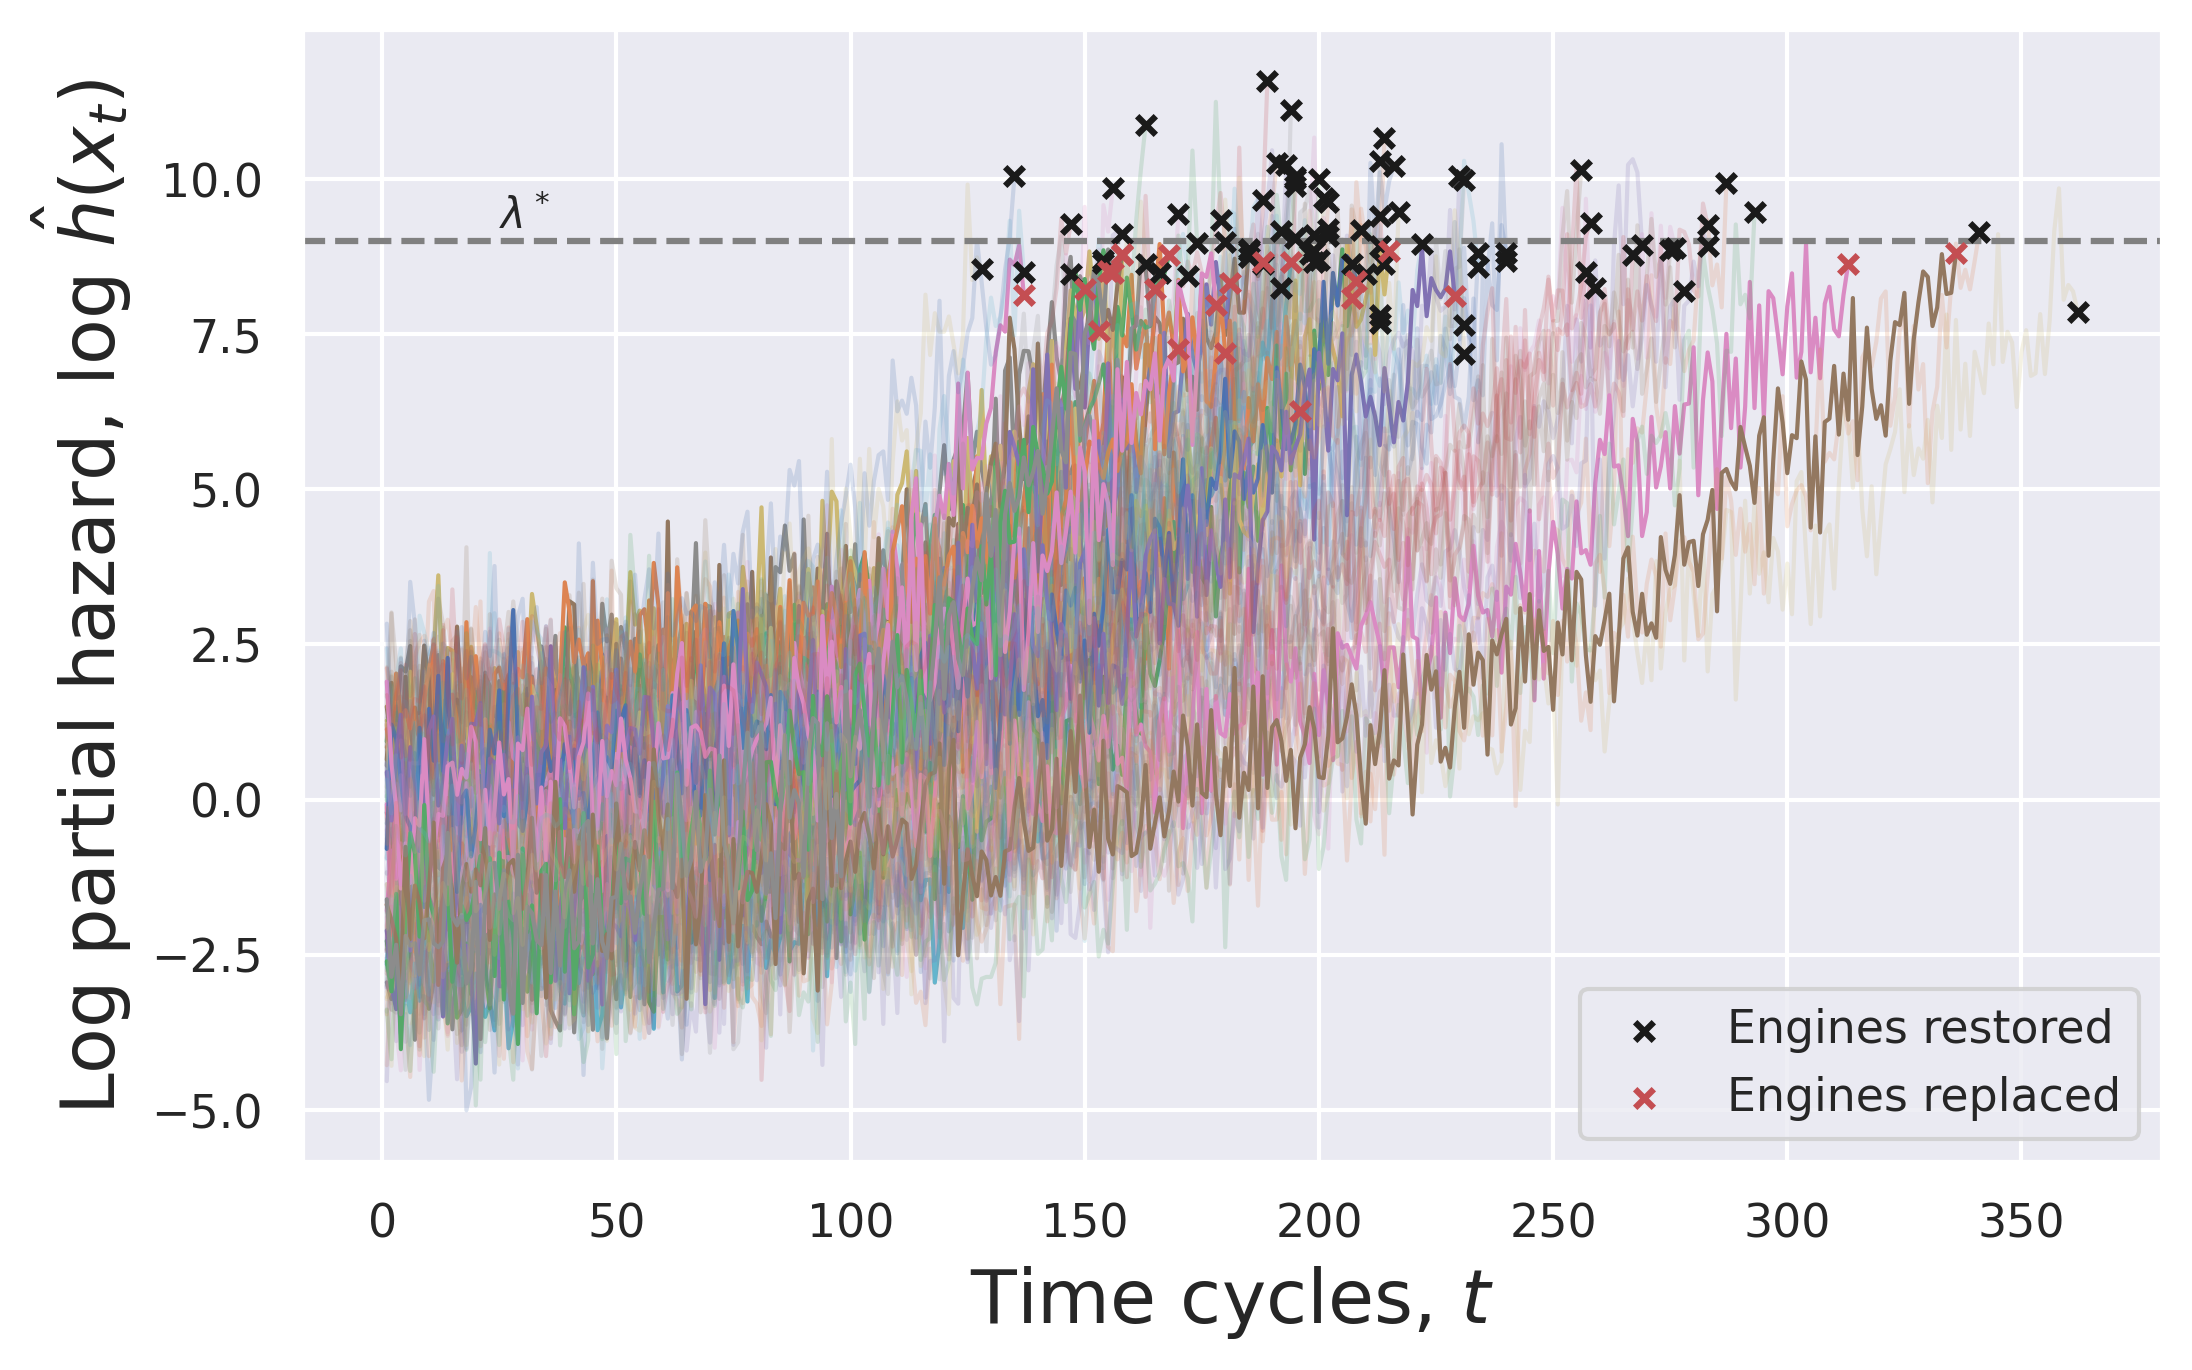

In [22]:
plt.figure(figsize=(8,5), dpi=300)
df_X = X
engines_restored = []
engines_replaced = []
for i in trange(100):
    X_sub = df_X.loc[df_X['UnitNumber'] == i+1]
    predictions = cph.predict_partial_hazard(X_sub[pred_cols])
    log_partial_hazard = np.log(predictions)
    is_maintained = log_partial_hazard.max() > thres
    plt.plot(X_sub['Cycle'].values, log_partial_hazard, alpha=0.2+0.8*~is_maintained, lw=1)
        
    if is_maintained:
      engines_restored.append([np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]])      
    else:
      engines_replaced.append([np.array(X_sub['Cycle'].values)[-1], np.log(predictions).values[-1]])
engines_restored = np.array(engines_restored)
engines_replaced = np.array(engines_replaced)      

if len(engines_restored) > 0:
  plt.scatter(engines_restored[:, 0], engines_restored[:, 1], s=20, marker="x", zorder=10, c="k", label="Engines restored")  
if len(engines_replaced) > 0:
  plt.scatter(engines_replaced[:, 0], engines_replaced[:, 1], s=20, marker="x", zorder=10, c="r", label="Engines replaced")


plt.xlabel('Time cycles, $t$', fontsize=18)
plt.ylabel('Log partial hazard, $\log ~\hat{h}(x_t)$', fontsize=18)
plt.text(25, thres+0.2, '$\lambda^*$')
plt.legend(loc=4)
plt.axhline(thres, c='gray', linestyle="dashed")
plt.savefig('sim_result_fd00x.pdf', format="pdf")
plt.show()